In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
import math
import json
import pickle
import gzip
import tqdm
import collections.abc
from textwrap import wrap
from PIL import Image
from os.path import isfile

from causal_discovery import causal_discovery, remove_empty
from tigramite import plotting as tp

from crp.image import imgify
from compute_normal_measures import AllMeasures
from helper import init_experiment

# Reload When Changed
%reload_ext autoreload
%autoreload 2

# Latex Rendering of Text in MPL
plt.rcParams['text.usetex'] = True
mpl.rcParams.update({'font.family': 'serif', "font.size": 20})

# To prevent requires grad errors 
torch.set_grad_enabled(False) 

In [3]:
# Select Experiment
EXPERIMENT = 1
with open("outputs/name_dict.json", "r") as f:
    NAME_DICT = json.load( f)
    ALL_MEASURES = list(NAME_DICT.keys())

In [4]:
# Initialize Parameters Depending on Experiment
(
    sample_set_size,
    iterations,
    layer_name,
    is_random,
    model_path,
    experiment_name,
    model_type,
    Datasettype,
    mask,
    accuracypath,
    relsetds,
) = init_experiment(EXPERIMENT)

ms = AllMeasures(
    "dsprites-dataset/images/",
    sample_set_size,
    layer_name,
    model_path,
    experiment_name,
)

BIASES = list(np.round(np.linspace(0, 1, 51), 3))


def load_measure(path, dimensions, isgzip=False):
    if isfile(path):
        if path.endswith("json"):
            with open(path, "r") as f:
                data = json.load(f)
                return data
        if path.endswith("pickle"):
            if isgzip:
                with gzip.open(path, "rb") as f:
                    data = pickle.load(f)
                    return data
            with open(path, "rb") as f:
                data = pickle.load(f)
                return data
    return torch.zeros(dimensions)

In [9]:
# Load All Measures
per_sample = load_measure(
    f"outputs/measures/all_measures_{sample_set_size}_{experiment_name}.pickle",
    (51, iterations, sample_set_size, len(ALL_MEASURES) - 20),
    isgzip=True,
)
rel_max_m = load_measure(
    f"outputs/measures/relmax_measures_{sample_set_size}_{experiment_name}.pickle",
    (51, iterations, 20),
    isgzip=True,
)
mostimportantneuron = load_measure(
    f"outputs/measures/mostimportantneuron_{experiment_name}.pickle",
    (51, iterations, 3),
    isgzip=True,
)

perseed_all = torch.zeros(51, iterations, per_sample.shape[3] + rel_max_m.shape[2] + mostimportantneuron.shape[3])
perseed_all[:, :, : per_sample.shape[3]] = per_sample.mean(dim=2)
perseed_all[:, :, per_sample.shape[3] :-3] = rel_max_m
perseed_all[:, :, -3:] = mostimportantneuron.mean(dim=2)
perseed_all.requires_grad = False

per_sample_all = torch.zeros(
    51, iterations, sample_set_size, per_sample.shape[3] + rel_max_m.shape[2]+ mostimportantneuron.shape[3]
)
per_sample_all[:, :, :, : per_sample.shape[3]] = per_sample
per_sample_all[:, :, :, per_sample.shape[3] :-3] = rel_max_m[:, :, None, :]
per_sample_all[:, :, :, -3:] = mostimportantneuron
per_sample_all.requires_grad = False

shape_gt = load_measure(
    f"outputs/measures/shape_gt_128_{experiment_name}.pickle", (51, iterations, 3)
)
pf_gt = load_measure(
    f"outputs/measures/pf_128_{experiment_name}.pickle", (51, iterations, 1)
)
nvals = load_measure(
    f"outputs/measures/nvals_{experiment_name}.json", (51 * iterations)
)

m0_path = f"outputs/measures/gt_phi.pickle"
watermark_flip_m0 = load_measure(m0_path, (51))
blub = watermark_flip_m0
if not isfile(m0_path):
    from sklearn.metrics import matthews_corrcoef

    for i, b in enumerate(BIASES):
        ds = Datasettype(b, 0.5, False)
        pred_labels = torch.from_numpy(ds.watermarks)
        true_labels = torch.from_numpy(ds.labels[:491520, 1])
        watermark_flip_m0[i] = 1 - (
            2 * torch.count_nonzero(pred_labels != true_labels) / pred_labels.shape[0]
        )
        blub[i] = matthews_corrcoef(true_labels, pred_labels)
    with open(m0_path, "wb") as f:
        pickle.dump(watermark_flip_m0, f)

with open(accuracypath, "r") as jf:
    accuracies = json.load(jf)

max_values = torch.max(per_sample_all, dim=2).values.max(dim=1).values.max(dim=0).values

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/retrain.json'

In [6]:
# SHOW CERTAIN MEASURES

mpl.rcParams.update({"font.family": "serif", "font.size": 32})
markerstyles = [
    "d",
    "x",
    "v",
    "s",
    "^",
    "P",
    "<",
    "*",
    ">",
    "X",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
]

regioncols = [0, 1, 1, 2, 2, 4, 4]
regionmarkers = ["d", "x", "x", "v", "v", "s", "s"]

refsetcols = [0, 4, 5, 2, 3]


def draw_measures(
    perseed_all,
    ptype=["m1_mlc_abs"],
    with_title=False,
    errormargin=False,
    minmax=False,
    scatter=False,
    norm="no",
):
    if isinstance(ptype, collections.abc.Sequence) and (not isinstance(ptype, str)):
        plot_variables = [
            [ALL_MEASURES.index(n) for n in ptype],  # type: ignore
            "comparison",
            "Effect of intervention on $W$",
            -0.17 * max(len(ptype) // 3, 1),
            3,
        ]
    else:
        plot_variables = [
            [ALL_MEASURES.index(ptype)],
            NAME_DICT[ptype],
            "change",
            -0.14,
            1,
        ]
    used_measures = plot_variables[0]
    ls = ["dashdot", "dotted", "solid"]
    colors = mpl.cm.tab10(
        np.linspace(0, 1, max(len(used_measures), 10))
    )  # ["#f00", "#088"]#
    plt.figure(figsize=(15, 12))
    plt.ylim([0, 1.0])
    #plt.tick_params(axis="y",direction="in", pad=-50)
    for en, i in enumerate(used_measures):
        l = ALL_MEASURES[i]
        # Styling measures' line
        label = "\n".join(wrap(NAME_DICT[l], 28))
        linestyle = ls[int(l[1])]
        linewidth = 4 if l == "m1_mlc_cosine" else 3
        marker = markerstyles[en] if int(l[1]) > 1 else ""
        if used_measures[-1] < 5:
            marker = markerstyles[en]
            linestyle = "solid"
        col = colors[en]
        if "neuron1" in l:
            linestyle = "dashed"
            marker = regionmarkers[en]
            col = colors[regioncols[en]]
        if "unweighted" in l:
            linestyle = "dashdot"
            marker = regionmarkers[en]
            col = colors[regioncols[en]]
        if ("weighted" in l or l == "rma") and len(used_measures) < 8:
            col = colors[regioncols[en]]
            marker = regionmarkers[en]
        if (l.startswith("m2_Rel") or l.startswith("m2_Act")) and len(
            used_measures
        ) == 5:
            col = colors[refsetcols[en]]

        # Normalizing or Scaling if needed
        normed = perseed_all[:, :, i]
        if norm == "per_seed":
            normed = normed / normed.max()
        if norm == "per_sample":
            normed = normed / max_values[i]
        if norm == "mean":
            normed = normed / normed.mean()
        vals = torch.abs(torch.mean(normed, dim=1))
        if norm == "total":
            vals = vals / vals.max()
        if norm == "normalized":
            vals = (vals - vals.min()) / (vals.max() - vals.min())

        """ if l == "m1_mlc_euclid":
            vals = vals * math.sqrt(2)
        if l == "m2_mac_l2square":
            vals = vals / perseed_all[:, :, i].max() """


        plt.plot(
            BIASES,
            vals.detach().numpy(),
            label=label,
            linestyle=linestyle,
            c=col,
            marker=marker,
            linewidth=linewidth,
        )

        if errormargin:
            sigma = torch.std(normed, dim=1) / math.sqrt(iterations)
            plt.fill_between(
                BIASES,
                vals + sigma,
                vals - sigma,
                facecolor=colors[en],
                alpha=0.3,
            )
        if minmax:
            vmin = torch.min(normed, dim=1).values
            vmax = torch.max(normed, dim=1).values
            plt.fill_between(
                BIASES,
                vmax,
                vmin,
                facecolor="#999",
                alpha=0.3,
            )
        if scatter:
            plt.scatter(
                [b for b in BIASES for i in range(iterations)],
                (perseed_all[:, :, i] / perseed_all[:, :, i].max()),
                c=colors[en],
                alpha=0.2,
            )
    if with_title:
        plt.title(plot_variables[1])
    plt.xlabel("coupling ratio $\\rho$")

    """ plt.legend(
        bbox_to_anchor=(0.0, plot_variables[3], 1.0, 0.102),
        loc="lower left",
        ncols=plot_variables[4],
        mode="expand",
        borderaxespad=0.0,
    ) """
    # plt.scatter([0.72, 0.82], [0, 0], color="black", s=70)
    # plt.legend(loc="upper left")
    if EXPERIMENT :
        plt.legend(loc="upper left")
        plt.ylabel(plot_variables[2])
        """ plt.legend(
            bbox_to_anchor=(1, 0.5),
            loc=6,
            ncols=1,
            labelspacing=0.8,
        ) """
    #else:



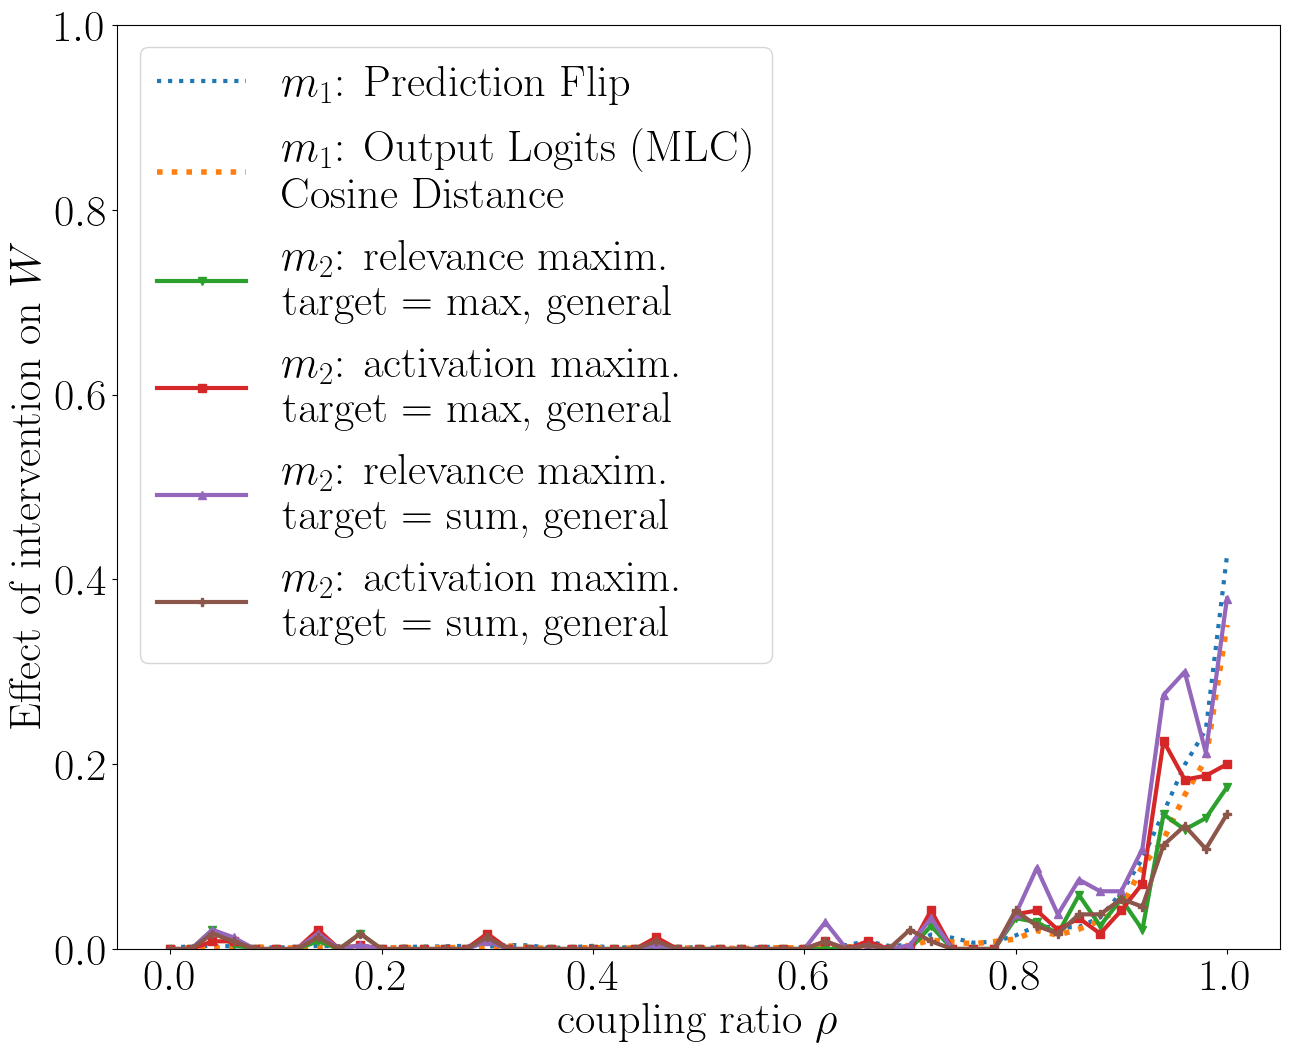

In [7]:
draw_measures(
    perseed_all,
    [
         "m1_phi",
        # "m1_mlc_abs",
        "m1_mlc_cosine",
        # "m1_mlc_euclid",
        # "m1_mlc_l2square",
        # "m2_rel_abs",
        #"m2_rel_cosine",
        # "m2_rel_euclid",
        # "m2_rel_l2square",
        # "m2_mac_abs",
        # "m2_mac_euclid",
        #"m2_mac_cosine",
        # "m2_mac_l2square",
        # "m2_rma",
        # "m2_rma_neuron1",
         #"m2_rma_unweighted",
        # "m2_pg_weighted",
        # "m2_pg_neuron1",
        #"m2_pg_unweighted",
        # "m2_rra_weighted",
        # "m2_rra_neuron1",
        ##"m2_rra_unweighted",
         "m2_Rel_max_diff",
         #"m2_Rel_max_m_rels",
        # "m2_Rel_max_stats",
         #"m2_Rel_max_stats_diff",
         "m2_Act_max_diff",
         #"m2_Act_max_m_rels",
        # "m2_Act_max_stats",
         ##"m2_Act_max_stats_diff",
        "m2_Rel_sum_diff",
         #"m2_Rel_sum_m_rels",
        #"m2_Rel_sum_stats",
         #"m2_Rel_sum_stats_diff",
        "m2_Act_sum_diff",
         #"m2_Act_sum_m_rels",
         #"m2_Act_sum_stats",
         #"m2_Act_sum_stats_diff",
    ],
    scatter=False,
    norm="no",
)

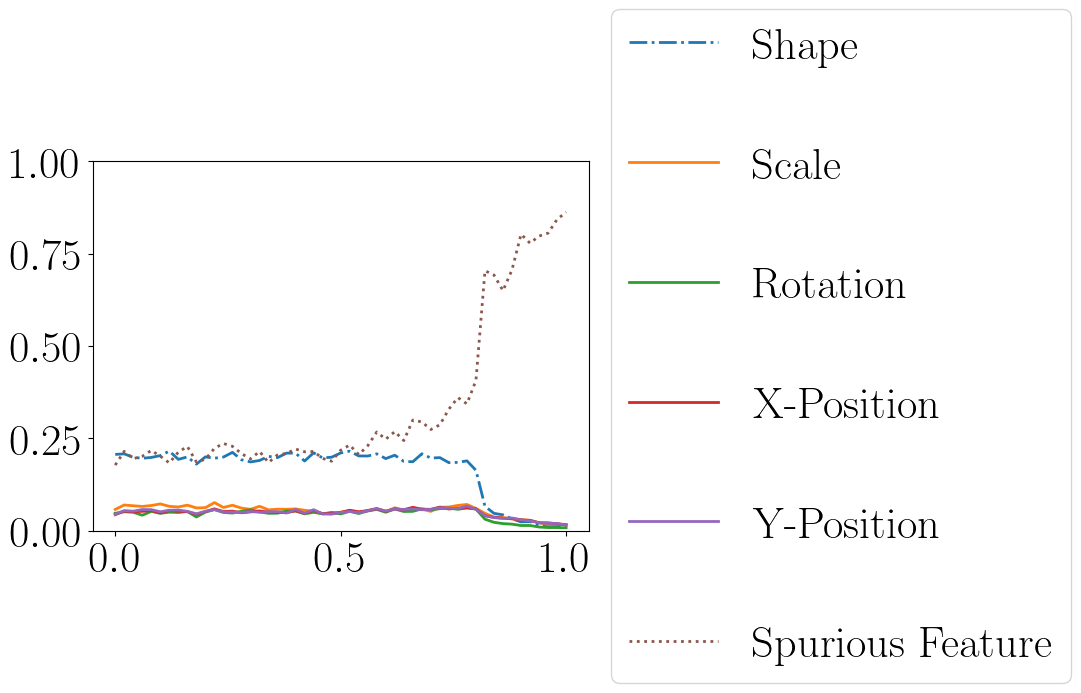

In [436]:
# Latent Factors
with gzip.open(
    f"outputs/measures/all_latent_factors_{sample_set_size}_{experiment_name}.pickle", "rb"
) as f:
    all_latent_factors = pickle.load(f)

LF_NAMES = [
    "shape_prediction_flip",
    "shape_mlc",
    "shape_rel_change",
    "scale_prediction_flip",
    "scale_mlc",
    "scale_rel_change",
    "rotation_prediction_flip",
    "rotation_mlc",
    "rotation_rel_change",
    "pos_x_prediction_flip",
    "pos_x_mlc",
    "pos_x_rel_change",
    "pos_y_prediction_flip",
    "pos_y_mlc",
    "pos_y_rel_change",
]

ls = [":", "dashdot", "dotted", ":", (0, (3, 1, 1, 1, 1, 1))]
usenames = [
    # "shape_prediction_flip",
    #"shape_mlc",
    "shape_rel_change",
    # "scale_prediction_flip",
    #"scale_mlc",
    "scale_rel_change",
    # "rotation_prediction_flip",
    #"rotation_mlc",
    "rotation_rel_change",
    # "pos_x_prediction_flip",
    #"pos_x_mlc",
    "pos_x_rel_change",
    # "pos_y_prediction_flip",
    #"pos_y_mlc",
    "pos_y_rel_change",
]
names_dict = {
    "shape_prediction_flip": "Shape Prediction Flip",
    "shape_mlc": "Shape Mean Logit Change",
    "shape_rel_change": "Shape",
    "scale_prediction_flip": "Scale Prediction Flip",
    "scale_mlc": "Scale Mean Logit Change",
    "scale_rel_change": "Scale",
    "rotation_prediction_flip": "Rotation Prediction Flip",
    "rotation_mlc": "Rotation Mean Logit Change",
    "rotation_rel_change": "Rotation",
    "pos_x_prediction_flip": "X-Position Prediction Flip",
    "pos_x_mlc": "X-Position Mean Logit Change",
    "pos_x_rel_change": "X-Position",
    "pos_y_prediction_flip": "Y-Position Prediction Flip",
    "pos_y_mlc": "Y-Position Mean Logit Change",
    "pos_y_rel_change": "Y-Position",
}
for l, namef in enumerate(LF_NAMES):
    if namef in usenames:
        if namef.startswith("shape"):
            ls = "dashdot"
        else:
            ls = "solid"
        plt.plot(
            BIASES,
            torch.mean(all_latent_factors[:, :, l], dim=1),
            label=names_dict[namef],
            linestyle=ls,
            linewidth=2,
        )

plt.plot(
    BIASES,
    torch.mean(perseed_all[:, :, 5], dim=1),
    label="Spurious Feature",  # Prediction Flip  Relevance Mean Logit Change
    linestyle="dotted",
    linewidth=2,
    # color="black"
)
plt.ylim([0.0, 1.0])

plt.legend(
    bbox_to_anchor=(1, 0.5),
    loc=6,
    ncols=1,
    labelspacing=1.8,
)

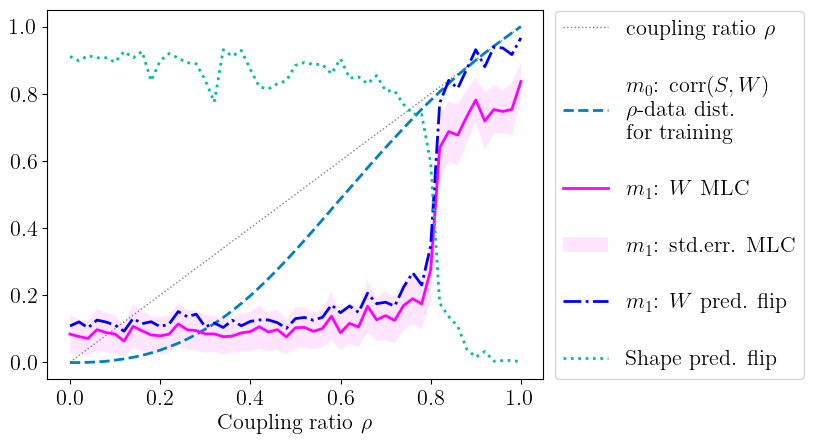

In [524]:
# Ground Truth Average

mpl.rcParams.update({'font.family': 'serif', "font.size": 16})
ecol = mpl.cm.winter(np.linspace(0, 1, 5))
scol = mpl.cm.spring(np.linspace(0, 1, 5))

plt.plot(
    BIASES,
    BIASES,
    linewidth=1,
    label="coupling ratio $\\rho$",
    linestyle="dotted",
    color="gray",
)
plt.plot(
    BIASES,
    watermark_flip_m0,
    linewidth=2,
    label="$m_0$: corr($S,W$) \n $\\rho$-data dist. \n for training",
    linestyle="dashed",
    color=ecol[2],
)

m1_mlc = torch.mean(per_sample[:, :, :, 2], dim=(1, 2))
m1_mlc_sigma = torch.std(per_sample[:, :, :, 2], dim=(1, 2)) / math.sqrt(iterations)

plt.plot(
    BIASES,
    m1_mlc,
    linewidth=2,
    label="$m_1$: $W$ MLC",
    # label="importance watermark (spurious feature)",
    color=scol[0],  # "#C8D672"
)
plt.fill_between(
    BIASES,
    m1_mlc + m1_mlc_sigma,
    m1_mlc - m1_mlc_sigma,
    facecolor=scol[0],  # "#C8D672",#
    label="$m_1$: std.err. MLC",
    alpha=0.1,
)

plt.plot(
    BIASES,
    torch.mean(per_sample[:, :, :, 0], dim=(1, 2)),
    linestyle="dashdot",
    linewidth=2,
    label="$m_1$: $W$ pred. flip",
    color=ecol[0],
)
plt.plot(
    BIASES,
    torch.mean(shape_gt[:, :, 2], dim=1),
    linestyle=":",
    linewidth=2,
    label="Shape pred. flip",
    # label="importance shape (target feature)",
    color=ecol[3],  # "red"#
)



plt.xlabel("Coupling ratio $\\rho$")
if EXPERIMENT == 2:
    plt.legend(
        bbox_to_anchor=(1, 0.5),
        loc=6,
        ncols=1,
        labelspacing=1.65,
    )
else:

    plt.ylabel("Importance")

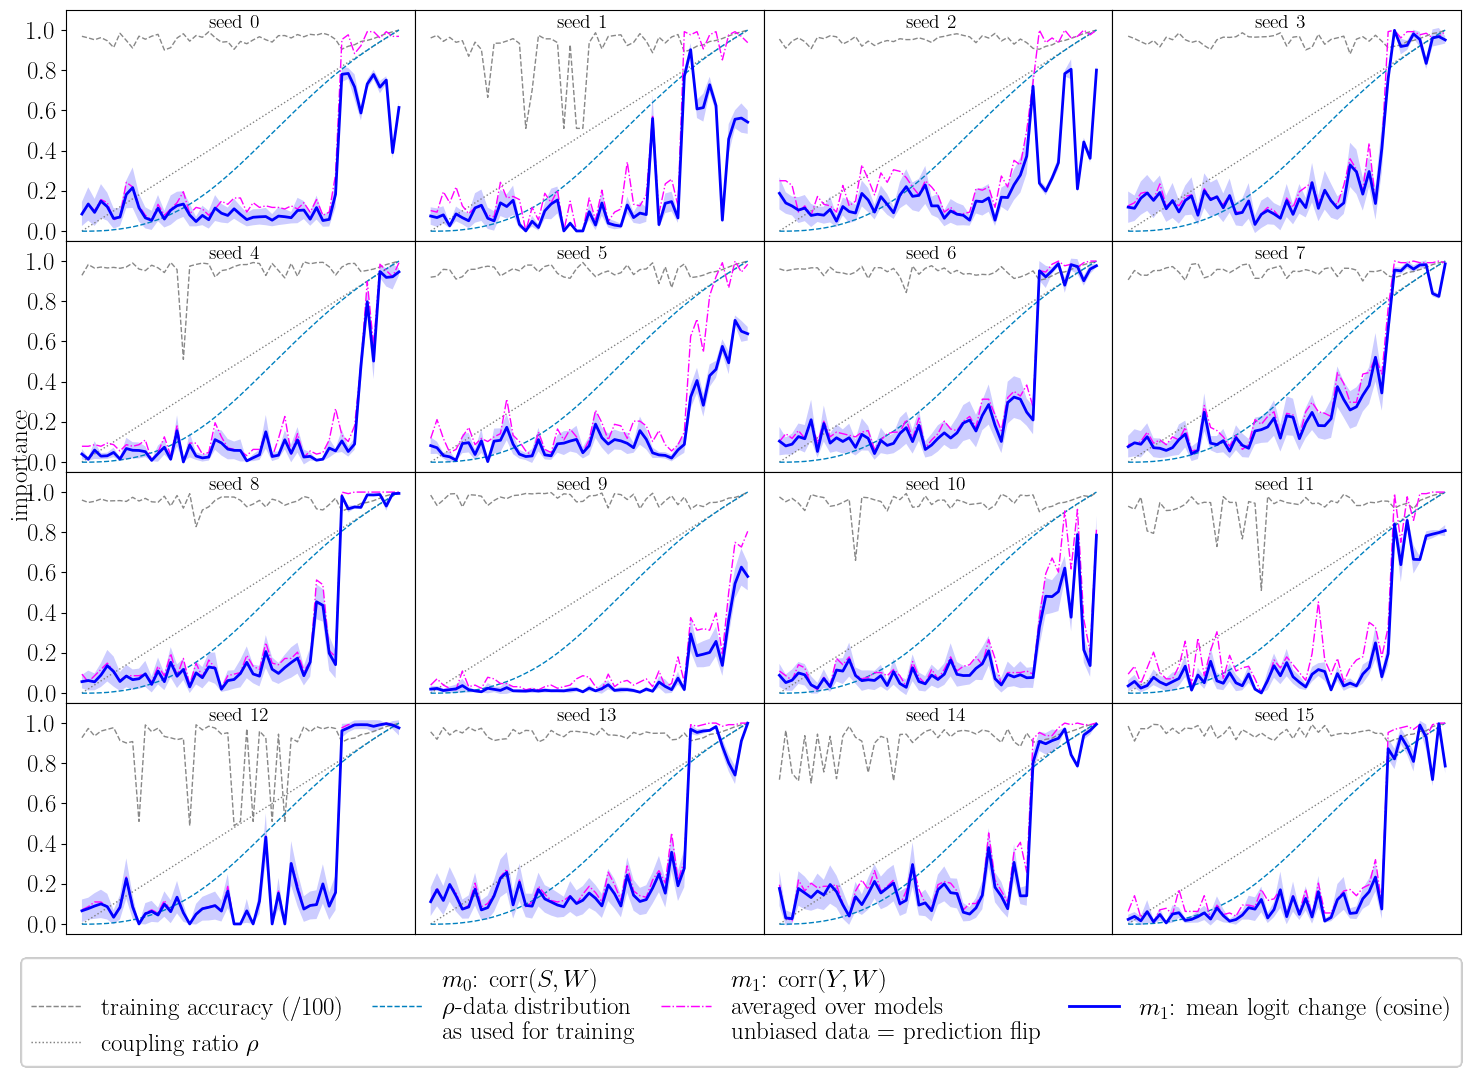

In [438]:
# Ground Truth Measures over seeds
ecol = mpl.cm.winter(np.linspace(0, 1, 5))
scol = mpl.cm.spring(np.linspace(0, 1, 5))
mpl.rcParams.update({'font.family': 'serif', "font.size": 18})


def to_name(b, i):
    return "b{}-i{}".format(
        str(round(b, 2)).replace(".", "_"),
        str(i),
    )


r, c = 2, 5

if iterations == 16:
    r, c = 4, 4


def axs_ind(s):
    return (s // c, s % c)


fig, axs = plt.subplots(
    r,
    c,
    figsize=(
        c * 4.5,
        r * 3,
    ),
    gridspec_kw={"wspace": 0.0, "hspace": 0},
)

fig.text(
    0.1,
    0.5,
    "importance",
    ha="center",
    va="center",
    rotation="vertical",
)
for s in range(iterations):
    names = [to_name(b, s) for b in BIASES]
    accuracy = np.array([accuracies[n]["train_accuracy"][2] / 100 for n in names])
    axs[axs_ind(s)].set_ylim([-0.05, 1.1])
    axs[axs_ind(s)].set_xlabel("$\\rho$")
    # axs[axs_ind(s)].set_ylabel("$\\phi$-correlation / importance")
    axs[axs_ind(s)].xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[axs_ind(s)].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    if (s // c) % r != 1:
        axs[axs_ind(s)].xaxis.set_visible(False)
    if s % c != 0:
        axs[axs_ind(s)].yaxis.set_visible(False)
    axs[axs_ind(s)].text(
        0.4,
        1.01,
        f"seed {s}",
        size=14,
    )
    axs[axs_ind(s)].plot(
        BIASES,
        accuracy,
        linewidth=1,
        linestyle="dashed",
        label="training accuracy (/100)" if s == 0 else "",
        color="#888",
    )
    axs[axs_ind(s)].plot(
        BIASES,
        BIASES,
        linewidth=1,
        label="coupling ratio $\\rho$" if s == 0 else "",
        linestyle="dotted",
        color="gray",
    )
    axs[axs_ind(s)].plot(
        BIASES,
        watermark_flip_m0,
        linewidth=1,
        label=(
            "$m_0$: corr($S,W$) \n $\\rho$-data distribution \n as used for training"
            if s == 0
            else ""
        ),
        linestyle="dashed",
        color=ecol[2],
    )

    """ sma = torch.nn.AvgPool1d(kernel_size=5, stride = 1, padding=2, count_include_pad=False)
    shape_avg = sma(shape_gt[:, s, 1].view(1,1,51))
    axs[axs_ind(s)].plot(
        BIASES,
        shape_avg[0,0,:],
        linestyle=":",
        linewidth=2,
        label="shape $\\phi$-coefficient corr($Y,S$)  \n averaged over models \n unbiased data",
        color=ecol[3],#"#f00"#
    ) """
    
    m1_mlc = torch.mean(per_sample[:, s, :, 2], dim=1)
    m1_mlc_sigma = torch.std(per_sample[:, s, :, 2], dim=1) / math.sqrt(iterations)

    axs[axs_ind(s)].fill_between(
        BIASES,
        m1_mlc + m1_mlc_sigma,
        m1_mlc - m1_mlc_sigma,
        facecolor=ecol[0],  # "#C8D672",#
        alpha=0.2,
    )

    m1_phi = torch.mean(per_sample[:, s, :, 0], dim=1)
    axs[axs_ind(s)].plot(
        BIASES,
        m1_phi,
        linewidth=1,
        linestyle="dashdot",
        label=(
            "$m_1$: corr($Y,W$)  \n averaged over models \n unbiased data = prediction flip"
            if s == 0
            else ""
        ),
        color=scol[0],
    )
    axs[axs_ind(s)].plot(
        BIASES,
        m1_mlc,
        linewidth=2,
        label="$m_1$: mean logit change (cosine)" if s == 0 else "",
        color=ecol[0],  # "#C8D672"#
    )
    fig.legend(
        bbox_to_anchor=(0.1, -0.15 if iterations == 10 else 0.0, 0.8, 0.102),
        loc="lower left",
        ncols=4,
        mode="expand",
        borderaxespad=0.0,
    )

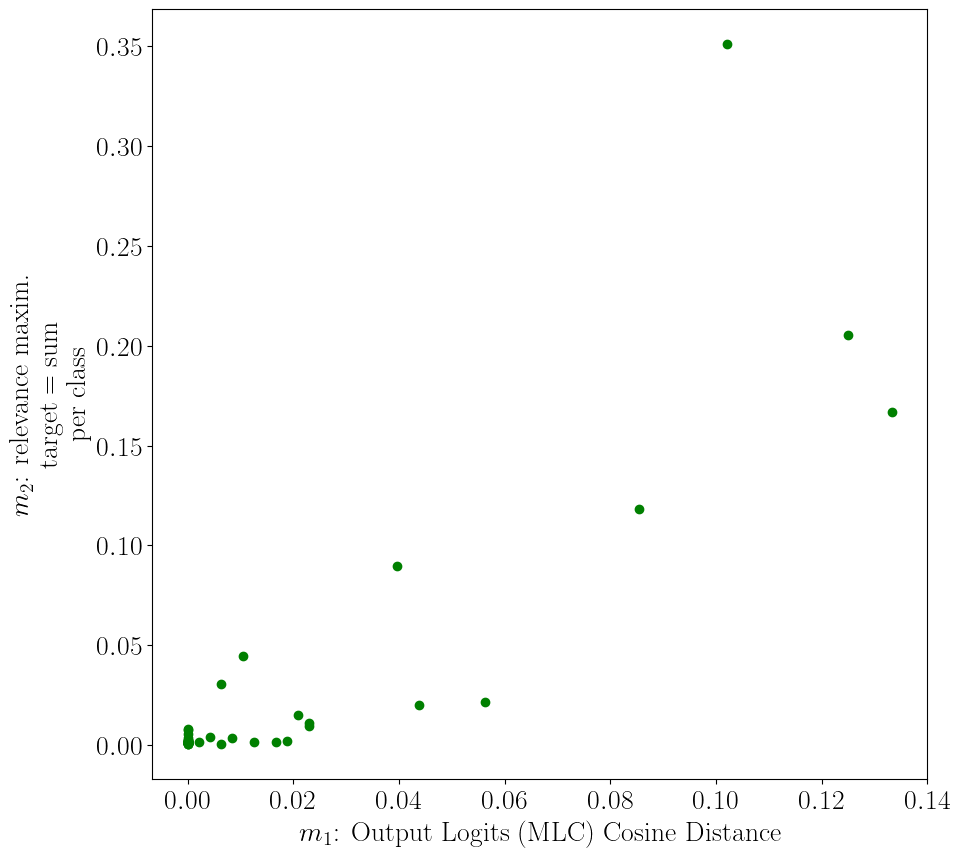

In [24]:
# Compare two measures with each other (mean plot or scatter plot)


def compare_two_measures(per_sample_all, a, b, per_seed_plot=True, mean_plot=False):
    m1 = ALL_MEASURES.index(a)
    m1_label = NAME_DICT[a]
    m2 = ALL_MEASURES.index(b)
    m2_label = NAME_DICT[b]
    c0 = mpl.cm.turbo(np.linspace(0, 1, iterations))
    if per_seed_plot:
        m1_val = per_sample_all[:, :, :, m1].mean(dim=(2)).flatten()
        m2_val = per_sample_all[:, :, :, m2].mean(dim=(2)).flatten()
        cols = [c0[i] for r in range(51) for i in range(iterations)]
    else:
        m1_val = per_sample_all[:, :, :, m1].flatten()
        m2_val = per_sample_all[:, :, :, m2].flatten()
        cols = [
            c0[i]
            for r in range(51)
            for s in range(sample_set_size)
            for i in range(iterations)
        ]

    cleg = [mpatches.Patch(color=cols[i], label=str(i)) for i in range(iterations)]
    plt.figure(figsize=(10, 10))
    plt.ylabel(m2_label)
    plt.xlabel(m1_label)
    if mean_plot:
        m1_val = per_sample_all[:, :, :, m1].mean(dim=(1, 2)).flatten()
        m2_val = per_sample_all[:, :, :, m2].mean(dim=(1, 2)).flatten()
        plt.scatter(
            m2_val,m1_val, label=f"{m1_label} vs. {m2_label}", color="green", alpha=1.0
        )
    else:
        plt.scatter(
            m2_val,
            m1_val,
            label=f"{m1_label} vs. {m2_label}",
            color=cols,
            alpha=1.0,
            s=70,
        )
        plt.legend(handles=cleg)


compare_two_measures(per_sample_all, "m1_mlc_cosine", "m2_Rel_sum_stats", True, True)

# "m1_phi",
# "m1_mlc_abs",
# "m1_mlc_euclid",
# "m1_mlc_l2square",
# "m1_mlc_cosine",
# "m2_rel_abs",
# "m2_rel_cosine",
# "m2_rel_euclid",
# "m2_rel_l2square",
# "m2_mac_abs",
# "m2_mac_euclid",
# "m2_mac_cosine",
# "m2_mac_l2square",
# "m2_rma",
# "m2_rra_weighted",
# "m2_pg_weighted",
# m2_pg_unweighted

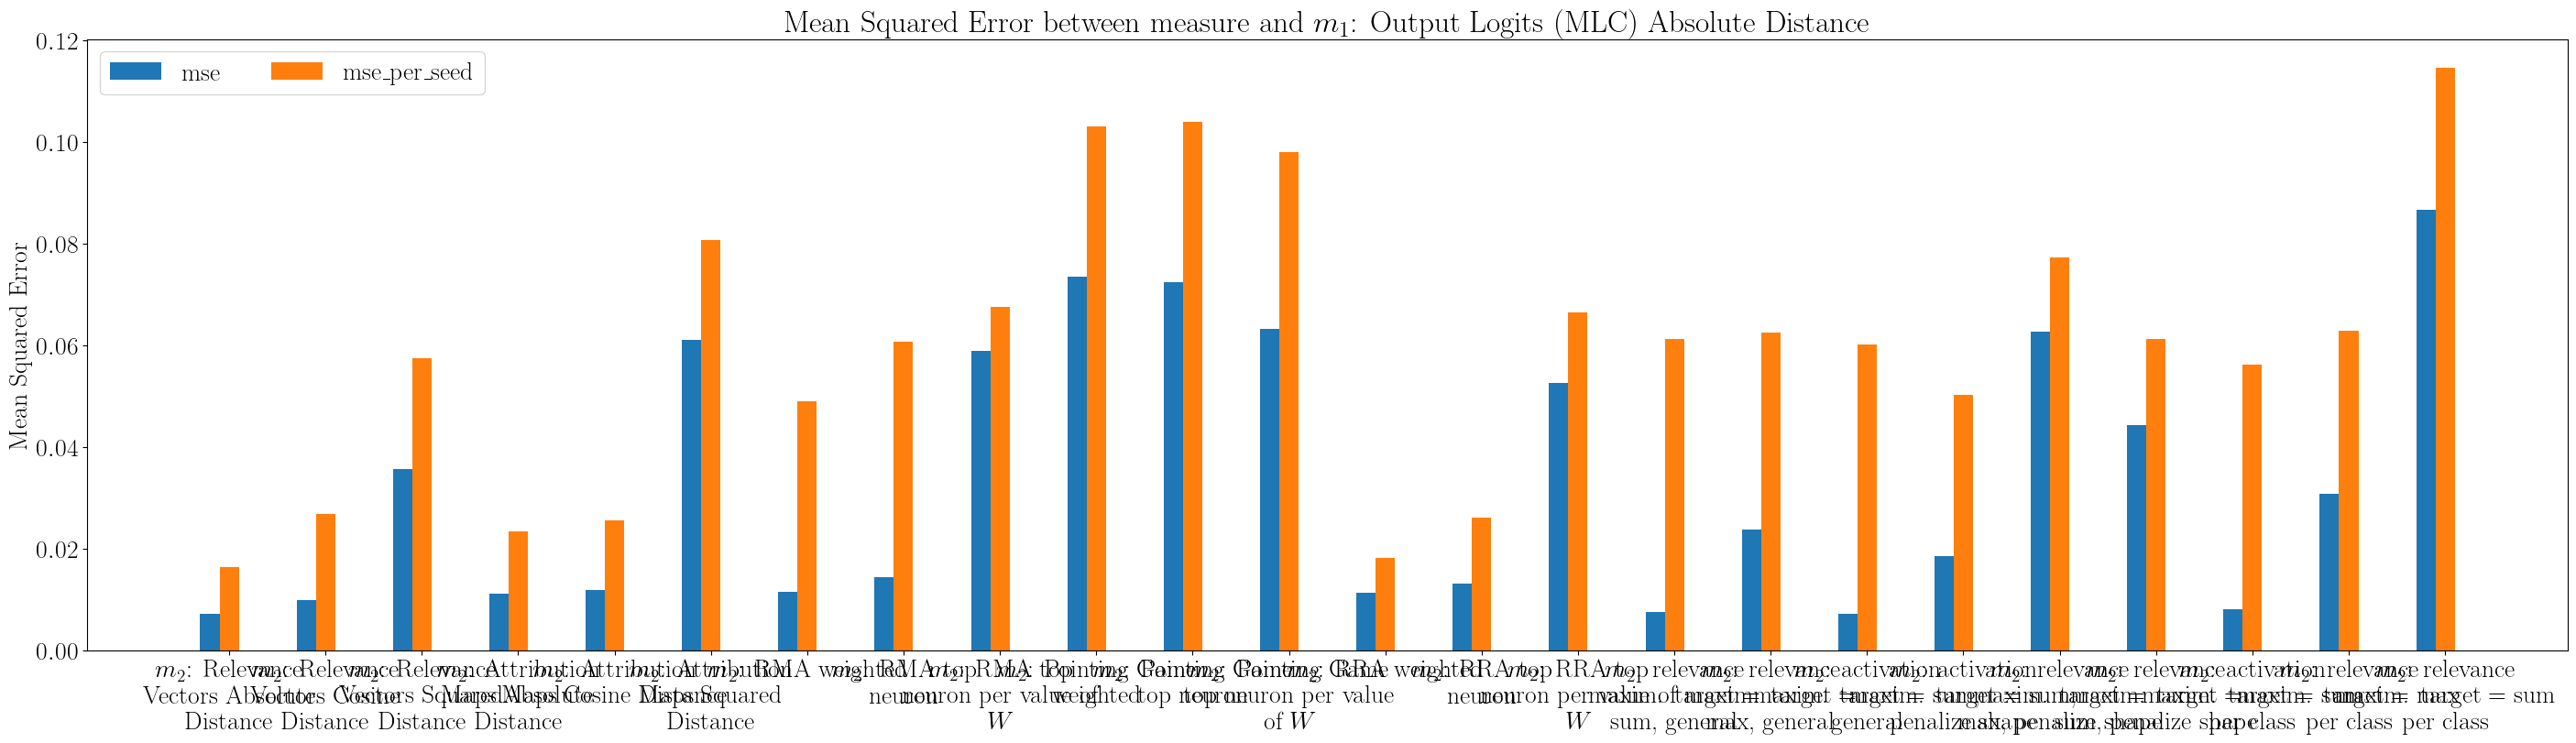

In [6]:
# Mean Squared Error

weights = torch.nn.functional.softmax(torch.tensor(BIASES), dim=0)
m1s = [
    # "m1_phi",
    # "m1_mlc_abs",
    # "m1_mlc_euclid",
    # "m1_mlc_l2square",
    "m1_mlc_cosine",
]

m2s = [
    "m2_rel_abs",
    "m2_rel_cosine",
    # "m2_rel_euclid",
     "m2_rel_l2square",
    "m2_mac_abs",
    # "m2_mac_euclid",
    "m2_mac_cosine",
     "m2_mac_l2square",
    "m2_rma",
    "m2_rma_neuron1",
    "m2_rma_unweighted",
    "m2_pg_weighted",
    "m2_pg_neuron1",
    "m2_pg_unweighted",
    "m2_rra_weighted",
    "m2_rra_neuron1",
    "m2_rra_unweighted",
    # "m2_Rel_max_diff",
    # "m2_Rel_max_m_rels",
    # "m2_Rel_max_stats",
    # "m2_Rel_max_stats_diff",
    # "m2_Act_max_diff",
    # "m2_Act_max_m_rels",
    # "m2_Act_max_stats",
    # "m2_Act_max_stats_diff",
    "m2_Rel_sum_diff",
    # "m2_Rel_sum_stats_diff",
    "m2_Rel_max_diff",
    "m2_Act_sum_diff",
    "m2_Act_sum_m_rels",
    "m2_Rel_max_m_rels",
    "m2_Rel_sum_m_rels",
    "m2_Act_sum_stats",
    "m2_Rel_max_stats",
    "m2_Rel_sum_stats",
    # "m2_Act_sum_stats_diff",
]


def mse(a, b):
    # return torch.nn.functional.mse_loss(a,b)
    return float(torch.mean(torch.square(a - b)))


def weighted_mse(a, b):
    if a.shape == (51, iterations):
        return torch.sum(torch.square((a - b)) * weights[:, None]) / iterations
    return torch.sum(torch.square((a - b)) * weights).float()


def r2_value(a, b):
    corr_matrix = np.corrcoef(a, b)  # actual, predict
    corr = corr_matrix[0, 1]
    R_sq = corr**2
    if np.isnan(R_sq):
        R_sq = 0.0
    return R_sq


mses = {}
r2s = {}
for_plot = {
    "mse": [],
    "weighted_mse": [],
    "r2": [],
    "r2_per_seed": [],
    "mse_per_seed": [],
    "weighted_mse_per_seed": [],
}

per_rho = torch.mean(perseed_all, dim=(1))  # filtered
per_seed = perseed_all / torch.tensor(
    [torch.max(perseed_all[:, :, i]) for i in range(42)]
)

""" print(
    per_seed.shape,
    per_rho.shape,
    torch.tensor([torch.max(perseed_all[:, :, i]) for i in range(42)]),
) """
m1_index = 1
m1_phi_vals = per_rho[:, m1_index]
m1_phi_valsps = per_seed[:, :, m1_index]
for measure in m2s:
    mk = ALL_MEASURES.index(measure)
    vals = per_rho[:, mk]  # / per_rho[:, mk].max()

    if measure == "m2_mac_l2square":
        vals = vals / perseed_all[:, :, mk].max()
    if measure == "m2_mac_euclid":
        vals = vals / perseed_all[:, :, mk].max()

    mses[measure] = {
        "mse": mse(m1_phi_vals, vals),
        "weighted_mse": round(float(weighted_mse(m1_phi_vals, vals)), 4),
        # "r2": r2_value(m1_phi_vals, vals),
        # "r2_per_seed": r2_value(m1_phi_valsps.flatten(), per_seed[:, :, mk].flatten()),
        # torch.mean(torch.tensor([r2_value(m1_phi_valsps[:,s], per_seed[:, s, mk]) for s in range(16)])),
        "mse_per_seed": round(mse(m1_phi_valsps, per_seed[:, :, mk]), 4),
        "weighted_mse_per_seed": round(
            float(weighted_mse(m1_phi_valsps, per_seed[:, :, mk])), 4
        ),
    }
    r2s[measure] = {
        "r2": round(float(r2_value(m1_phi_vals, vals)), 2),
        "r2_per_seed": round(
            float(r2_value(m1_phi_valsps.flatten(), per_seed[:, :, mk].flatten())), 2
        ),
    }
    for_plot["mse"].append(mses[measure]["mse"])
    for_plot["weighted_mse"].append(mses[measure]["weighted_mse"])
    # for_plot["r2"].append(mses[measure]["r2"])
    # for_plot["r2_per_seed"].append(mses[measure]["r2_per_seed"])
    for_plot["mse_per_seed"].append(mses[measure]["mse_per_seed"])
    for_plot["weighted_mse_per_seed"].append(mses[measure]["weighted_mse_per_seed"])


x = np.arange(len(mses.keys()))  # the label locations
fig, ax = plt.subplots(layout="constrained", figsize=(28, 8))
width = 0.2  # the width of the bars
multiplier = 0
for attribute in ["mse", "mse_per_seed"]:  # , "weighted_mse", "weighted_mse_per_seed"
    measurement = for_plot[attribute]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    f"Mean Squared Error between measure and {NAME_DICT[ALL_MEASURES[m1_index]]}"
)
ax.set_ylabel("Mean Squared Error")
# ax.set_ylim([0.0, 0.016])
ax.set_xticks(x + width, ["\n".join(wrap(NAME_DICT[k], 20)) for k in mses.keys()])
ax.legend(loc="upper left", ncols=4)
# ax.set_ylim(0, 1)

# print({k: {mses[ALL_MEASURES[a]]:round(float(v[a]),4) for a in range(len(v)) } for k,v in for_plot.items()})
with open(f"mses_{experiment_name}.json", "w") as f:
    json.dump({NAME_DICT[k]: mses[k] for k in mses.keys()}, f)
with open(f"r2s_{experiment_name}.json", "w") as f:
    json.dump({NAME_DICT[k]: r2s[k] for k in r2s.keys()}, f)

0 m2_rel_abs
1 m2_rel_cosine
2 m2_rel_l2square
3 m2_mac_abs
4 m2_mac_cosine
5 m2_mac_l2square
6 m2_rma
7 m2_rma_neuron1
8 m2_rma_unweighted
9 m2_pg_weighted
10 m2_pg_neuron1
11 m2_pg_unweighted
12 m2_rra_weighted
13 m2_rra_neuron1
14 m2_rra_unweighted
15 m2_Rel_sum_diff
16 m2_Rel_max_diff
17 m2_Act_sum_diff
18 m2_Act_sum_m_rels
19 m2_Rel_max_m_rels
20 m2_Rel_sum_m_rels
21 m2_Act_sum_stats
22 m2_Rel_max_stats
23 m2_Rel_sum_stats


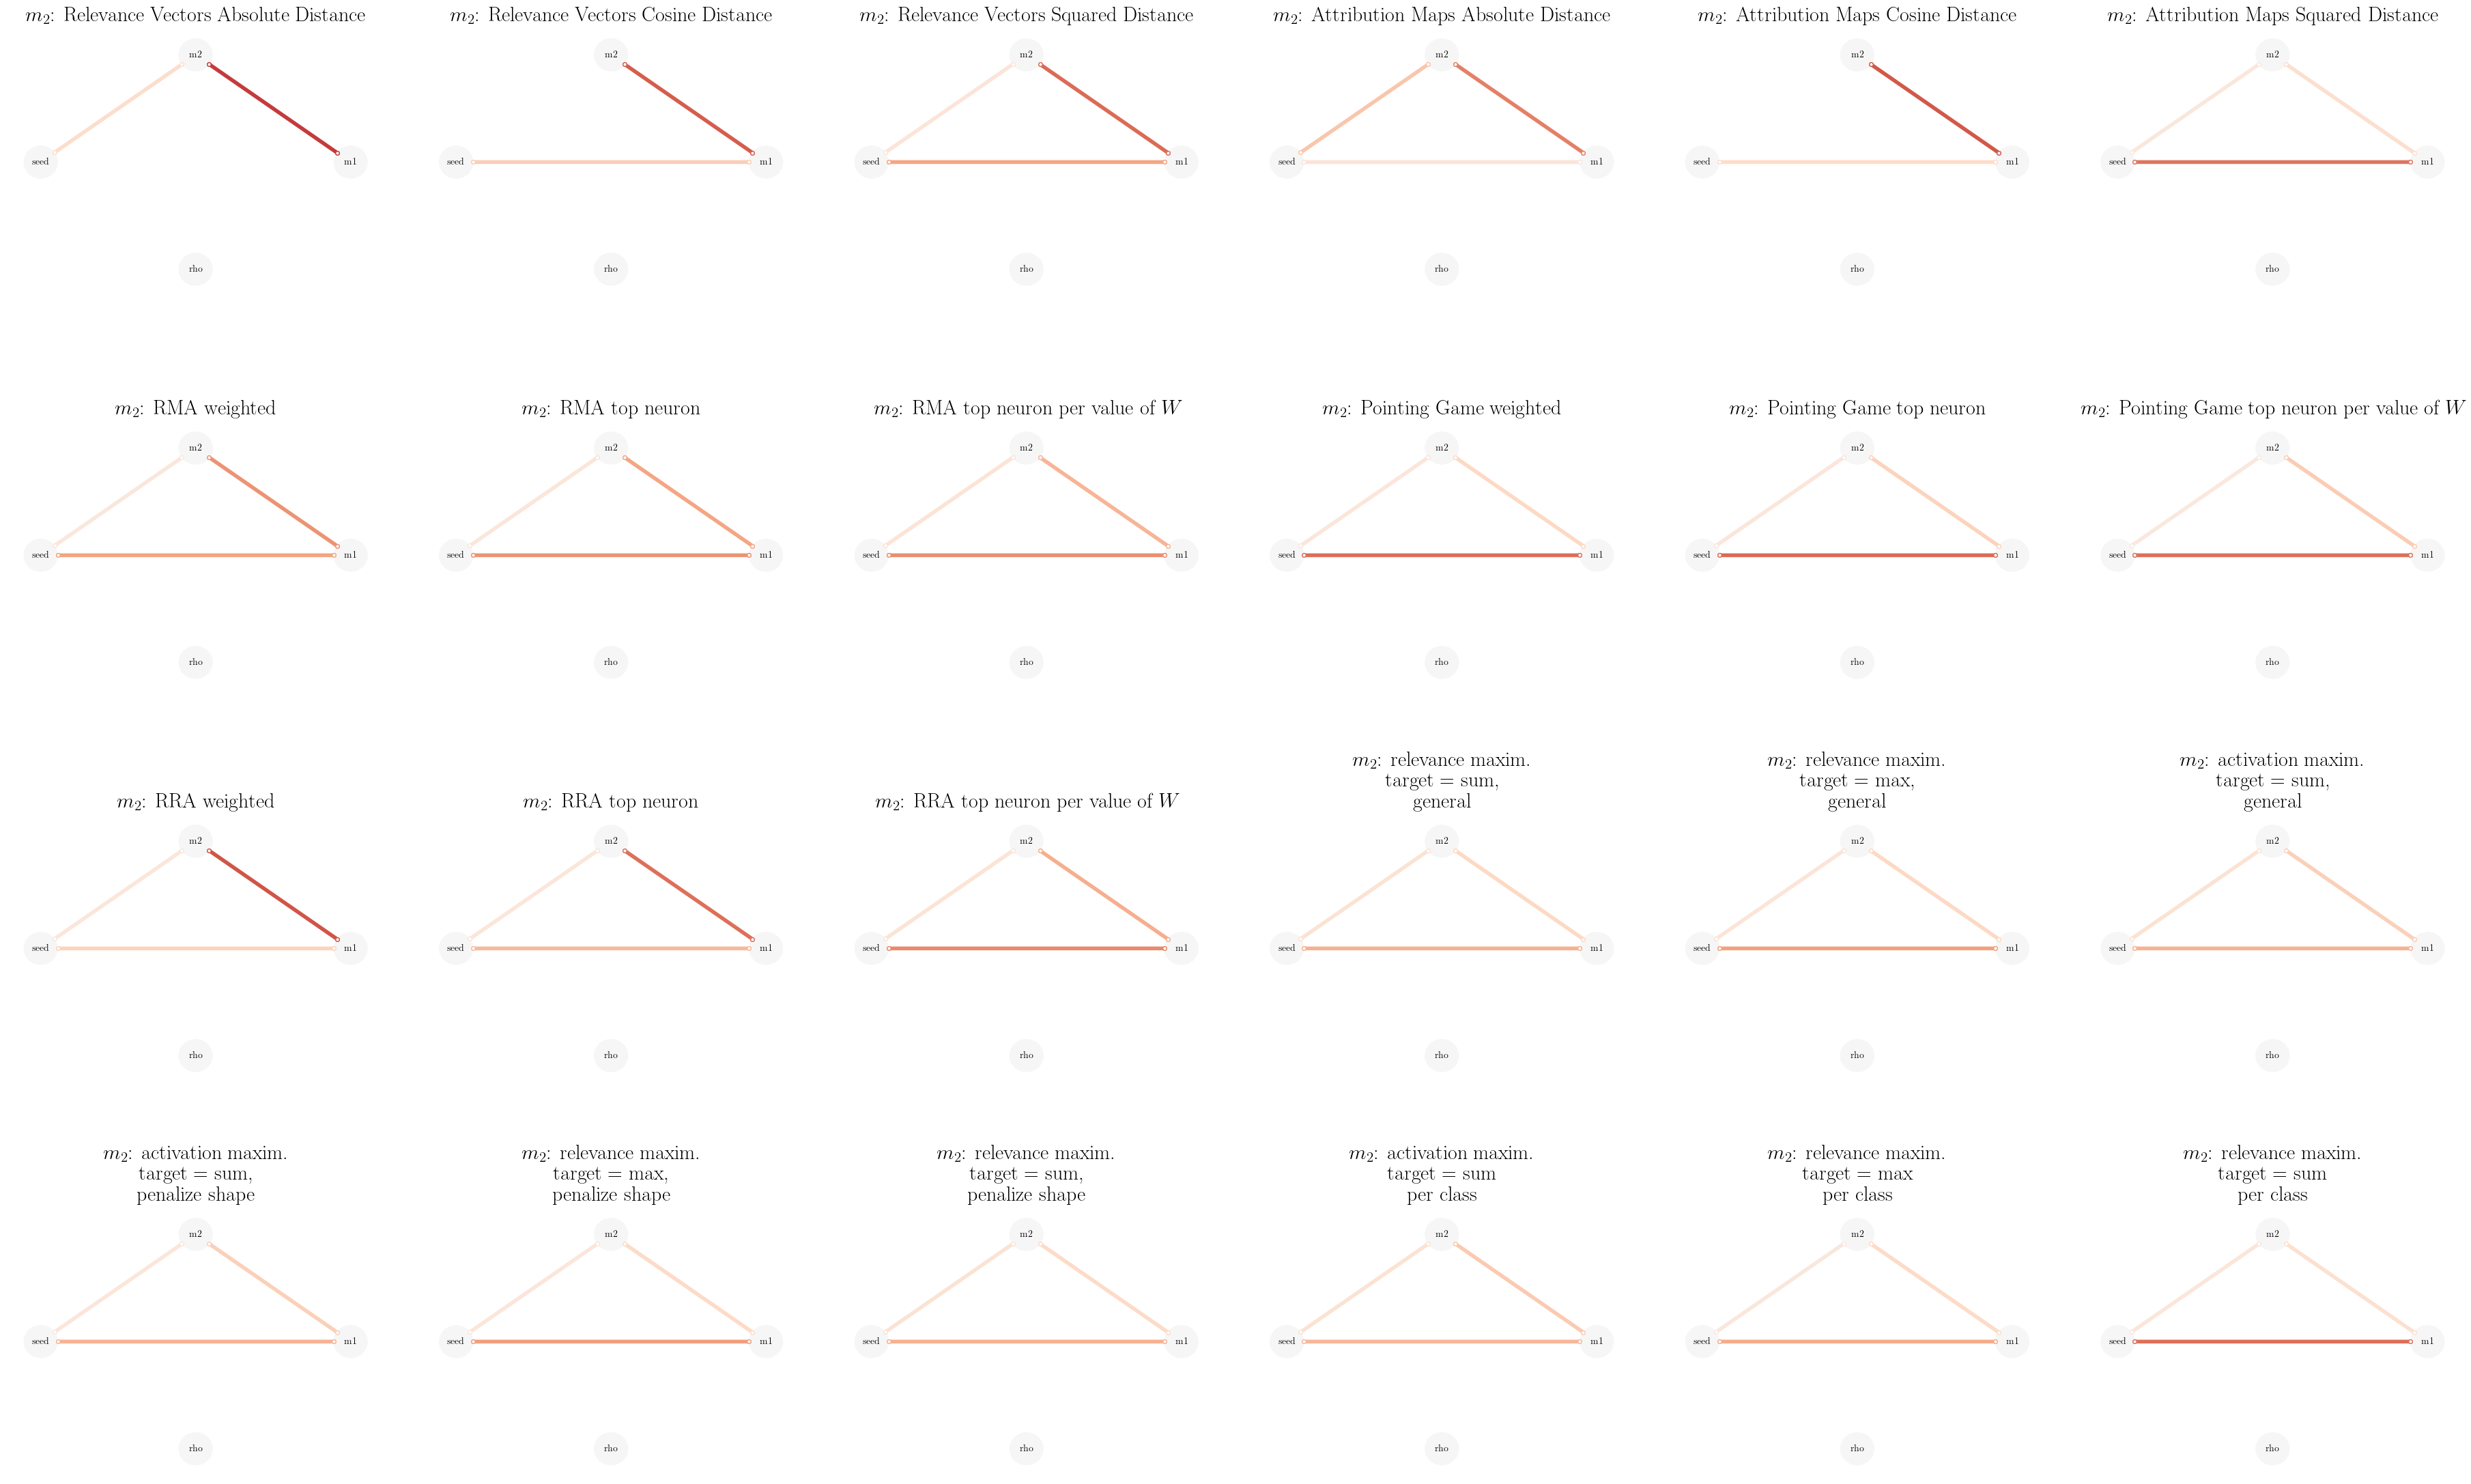

In [112]:

torch.set_grad_enabled(True) 

mpl.rcParams.update({"font.family": "serif", "font.size": 18})
dafr = torch.zeros(816, 4)
dafr[:, 2] = torch.tensor([i for i in range(iterations) for r in range(51)])
dafr[:, 3] = torch.tensor(
    [r for i in range(iterations) for r in BIASES]
)  # watermark_flip_m0

# plt.scatter(dafr[:,3], dafr[:,2])

fig, axs = plt.subplots(
    4,
    6,
    figsize=(
        8 * 5.8,
        6 * 4.6,
    ),
    gridspec_kw={"wspace": 0.1, "hspace": 0.45},
)
all_results = []


for i, m in tqdm(enumerate(m2s)):
    dafr[:, :2] = perseed_all[:, :, [0, ALL_MEASURES.index(m)]].flatten(0, 1)
    dataframe, var_names = remove_empty(
        dafr.numpy(),
        np.array(["m1", "m2", "seed", "rho"]),
        np.array([0, 0, 1, 0]),
        with_type=False,
    )
    results = causal_discovery(
        dataframe, test="GPDCtorch"
    )  # RobustParCorr RegressionCI CMIknnMixed GPDCtorch
    axie = plt.subplot(4,6,i+1)
    axie.set_title(NAME_DICT[m])

    tp.plot_graph(
        graph=results["graph"],
        fig_ax=(fig,axie),#axs[i // 6, i % 6],
        save_name=None,
        var_names=var_names,
        #node_size=1,
        #node_pos=node_pos,
        figsize=(12, 12),
        arrow_linewidth=4,
        val_matrix=results["val_matrix"],
        show_colorbar=False
    )
# plt.show()

In [125]:

from tigramite.causal_effects import CausalEffects
X = [(0,0)]
Y = [(1,0)]
graph = results["graph"]#.reshape((4,4))
causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                               #hidden_variables=hidden_variables, 
                               verbosity=1)

No causal path from X to Y exists.

##
## Initializing CausalEffects class
##

Input:

graph_type = stationary_dag
X = [(0, 0)]
Y = [(1, 0)]
S = []
M = []



No causal path from X to Y exists!


In [494]:
with open("mses_attribution_output.json", "r") as f:
    wm_mses = json.load(f)

with open("mses_overlap_attribution.json", "r") as f:
    pat_mses = json.load(f)

with open("r2s_attribution_output.json", "r") as f:
    wm_r2s = json.load(f)

with open("r2s_overlap_attribution.json", "r") as f:
    pat_r2s = json.load(f)
#print(pat_r2s, wm_r2s)
newdic = []
r2vals = []
for k in wm_mses.keys():
    newdic.append({"measure": k.replace("$m_2$: ", "").replace("\n", ""),
                   "MSE Per $\\rho$ watermark": round(wm_mses[k]["mse"],5),
                   "MSE Per Seed watermark": round(wm_mses[k]["mse_per_seed"],5),
                   "MSE Per $\\rho$ pattern": round(pat_mses[k]["mse"],5),
                   "MSE Per Seed pattern": round(pat_mses[k]["mse_per_seed"],5),
                   })
    r2vals.append({"measure": k.replace("$m_2$: ", "").replace("\n", ""),
                   "r2 Per $\\rho$ watermark": round(wm_r2s[k]["r2"],5),
                   "r2 Per Seed watermark": round(wm_r2s[k]["r2_per_seed"],5),
                   "r2 Per $\\rho$ pattern": round(pat_r2s[k]["r2"],5),
                   "r2 Per Seed pattern": round(pat_r2s[k]["r2_per_seed"],5),
                   })
print(r2vals)

[{'measure': 'Relevance Vectors Absolute Distance', 'r2 Per $\\rho$ watermark': 0.95, 'r2 Per Seed watermark': 0.91, 'r2 Per $\\rho$ pattern': 0.99, 'r2 Per Seed pattern': 0.85}, {'measure': 'Relevance Vectors Cosine Distance', 'r2 Per $\\rho$ watermark': 0.96, 'r2 Per Seed watermark': 0.9, 'r2 Per $\\rho$ pattern': 0.98, 'r2 Per Seed pattern': 0.64}, {'measure': 'Attribution Maps Absolute Distance', 'r2 Per $\\rho$ watermark': 0.95, 'r2 Per Seed watermark': 0.89, 'r2 Per $\\rho$ pattern': 0.95, 'r2 Per Seed pattern': 0.73}, {'measure': 'Attribution Maps Cosine Distance', 'r2 Per $\\rho$ watermark': 0.95, 'r2 Per Seed watermark': 0.88, 'r2 Per $\\rho$ pattern': 0.98, 'r2 Per Seed pattern': 0.69}, {'measure': 'RMA weighted', 'r2 Per $\\rho$ watermark': 0.96, 'r2 Per Seed watermark': 0.76, 'r2 Per $\\rho$ pattern': 0.96, 'r2 Per Seed pattern': 0.45}, {'measure': 'RMA top neuron', 'r2 Per $\\rho$ watermark': 0.98, 'r2 Per Seed watermark': 0.81, 'r2 Per $\\rho$ pattern': 0.94, 'r2 Per Seed

24


' norm = matplotlib.colors.Normalize(vmin=0, vmax=51)\nplt.colorbar(\n    cobj,\n    cax=axs[-1,0],\n    orientation="horizontal",\n    location="bottom",\n    label="\\rho value",\n) '

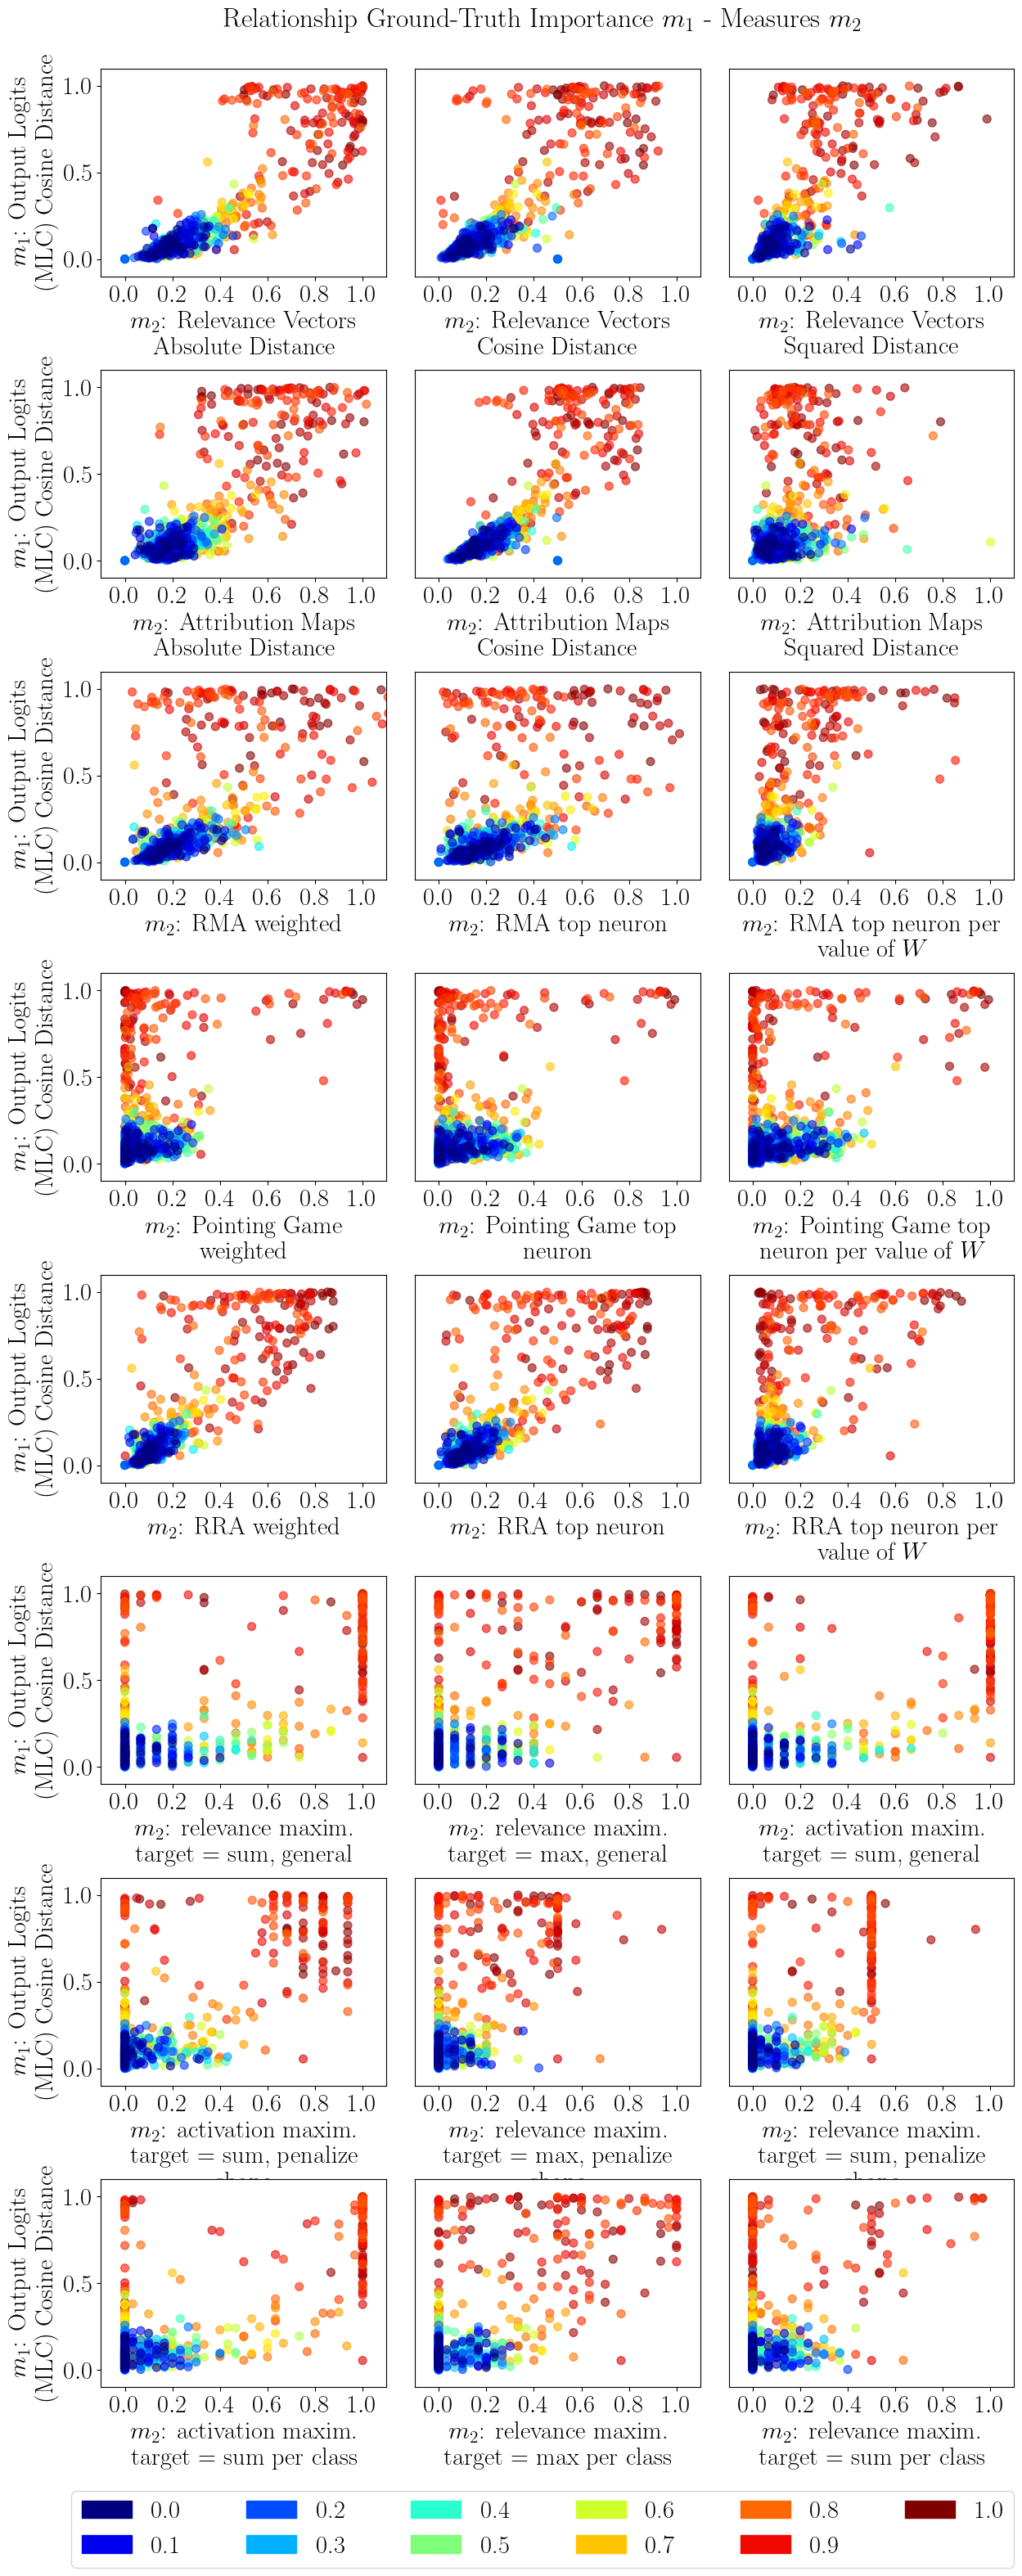

In [594]:
# Scatterplots

mpl.rcParams.update({"font.family": "serif", "font.size": 22})
modulo = 3
r = max(1, len(m2s) // modulo )
print(len(m2s))
c =  min(len(m2s) ,modulo) 

fig, axs = plt.subplots(
    r,c,
    figsize=(
        c * 4.8,
        r * 4.6,
    ),
    gridspec_kw={"wspace": 0.1, "hspace": 0.45},
)
fig.suptitle(
    "Relationship Ground-Truth Importance $m_1$ - Measures $m_2$",
    x=0.5,
    y=0.9,
    size=24,
)
plot_idx = list(
    range((iterations * 51 - 1), -1, -1)
)  # np.random.permutation(m1_val.shape[0])
colorvals = mpl.cm.jet(np.linspace(0, 1, 51))
cols = [colorvals[r] for r in range(51) for i in range(iterations)]
cleg = [
    mpatches.Patch(color=colorvals[i], label=str(BIASES[i])) for i in range(0, 51, 5)
]
color_seq = torch.tensor(cols)[plot_idx]
cm = plt.cm.jet


def ipl(i1, i2, lenm1):
    if lenm1 <= 1:
        if len(m2s) > modulo:
            return  i2 // modulo,i2 % modulo
        return i2
    return i1, i2


for m1i, m1 in enumerate(m1s):
    for m2i, m2 in enumerate(m2s):
        m1_index = ALL_MEASURES.index(m1)
        m1_label = NAME_DICT[m1]
        m2_index = ALL_MEASURES.index(m2)
        m2_label = NAME_DICT[m2]
        m1_val = perseed_all[:, :, m1_index].flatten()  # .flatten() #
        m2_val = perseed_all[:, :, m2_index].flatten()  # .flatten() #
        if m2 == "m2_mac_l2square":
            m2_val = m2_val / m2_val.max() # / (8 * perseed_all[:, :, m2_index].mean())
        axs[ipl(m1i, m2i, len(m1s))].set_ylim([-0.1, 1.1])
        axs[ipl(m1i, m2i, len(m1s))].set_xlim([-0.1, 1.1])
        axs[ipl(m1i, m2i, len(m1s))].set_xlabel("\n".join(wrap(m2_label, 25)))
        if m2i % modulo == 0:
            axs[ipl(m1i, m2i, len(m1s))].set_ylabel("\n".join(wrap(m1_label, 22)))
        else:
            axs[ipl(m1i, m2i, len(m1s))].yaxis.set_visible(False)
        axs[ipl(m1i, m2i, len(m1s))].xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        # axs[ipl(m1i, m2i, len(m1s))].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

        axs[ipl(m1i, m2i, len(m1s))].scatter(
            m2_val[plot_idx], m1_val[plot_idx], c=color_seq, alpha=0.6, s=50
        )  # color="black",

fig.legend(
    handles=cleg,
    bbox_to_anchor=(0.1, 0.05, .8, 0.2),
    loc="lower left",
    ncols=6,
    borderaxespad=0.0,
    mode="expand",
)
""" norm = mpl.colors.Normalize(vmin=0, vmax=51)
plt.colorbar(
    cobj,
    cax=axs[-1,0],
    orientation="horizontal",
    location="bottom",
    label="\\rho value",
) """

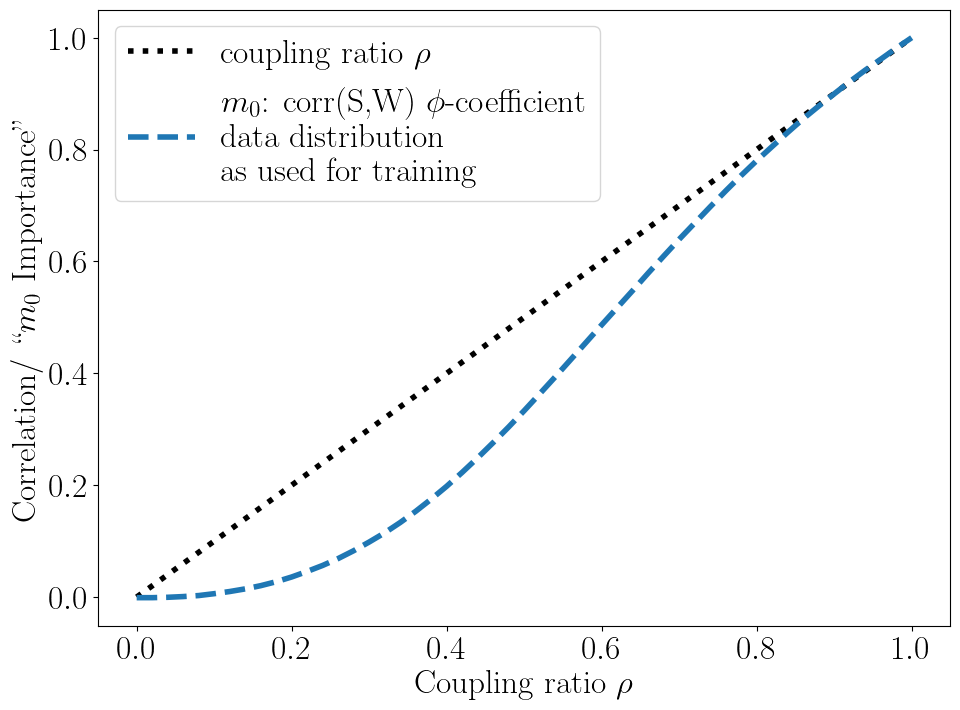

In [44]:
# Rho vs. Corr(W,S)

mpl.rcParams.update({"font.family": "serif", "font.size": 24})
fig = plt.figure(figsize=(11, 8))
fig.set_facecolor("#fff")
fig.set_alpha(0.0)
ax = fig.add_subplot(111)
ax.set_facecolor("#fff")
ax.set_alpha(0.0)
plt.plot(BIASES, BIASES, color="#000", label="coupling ratio $\\rho$", linewidth=4, linestyle="dotted")
plt.plot(BIASES, watermark_flip_m0, label="$m_0$: corr(S,W) $\\phi$-coefficient \n data distribution \n as used for training", linewidth=4, linestyle="dashed")


plt.ylabel("Correlation/ ``$m_0$ Importance\" ")
plt.xlabel("Coupling ratio $\\rho$")
plt.legend(loc="upper left")

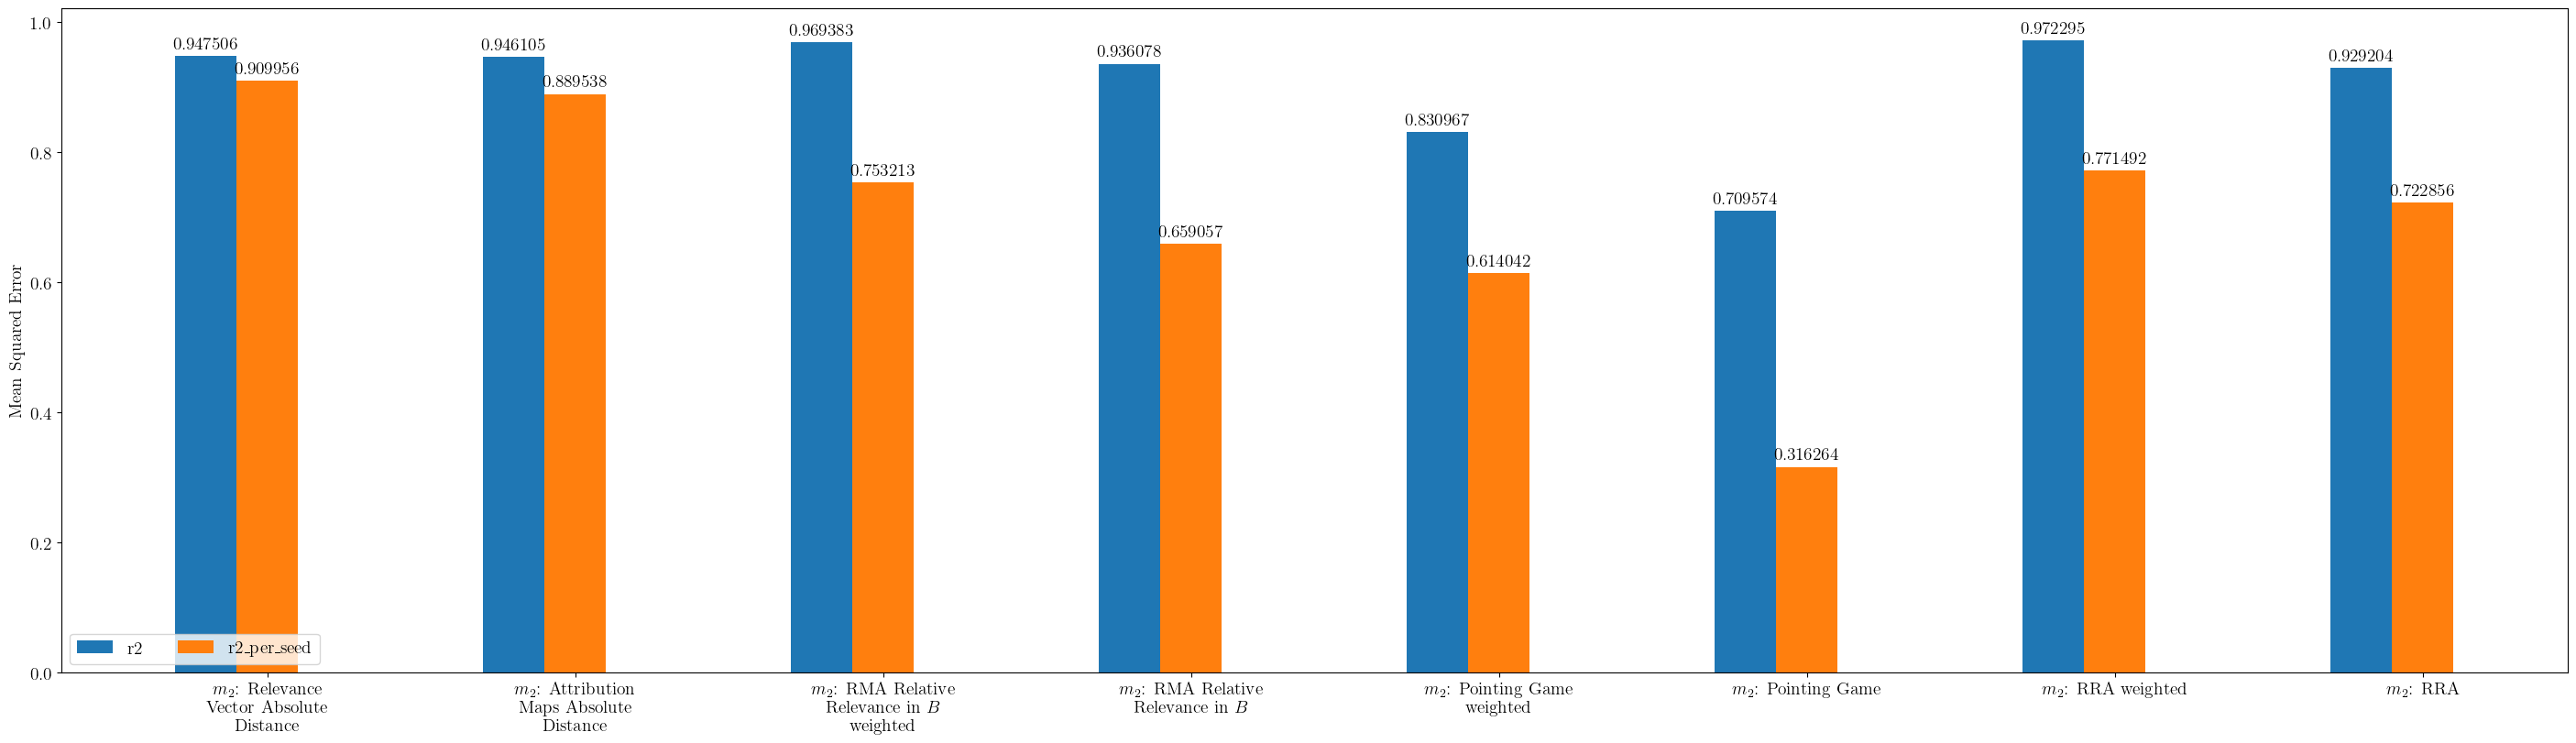

In [27]:
x = np.arange(len(mses.keys()))  # the label locations
fig, ax = plt.subplots(layout="constrained", figsize=(28, 8))
width = 0.2  # the width of the bars
multiplier = 0
for attribute in ["r2", "r2_per_seed"]:
    measurement = for_plot[attribute]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x + width, ["\n".join(wrap(NAME_DICT[k], 20)) for k in mses.keys()])
ax.legend(loc="lower left", ncols=3)
# ax.set_ylim(0, 1)

/tmp/ipykernel_1473472/1004671826.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


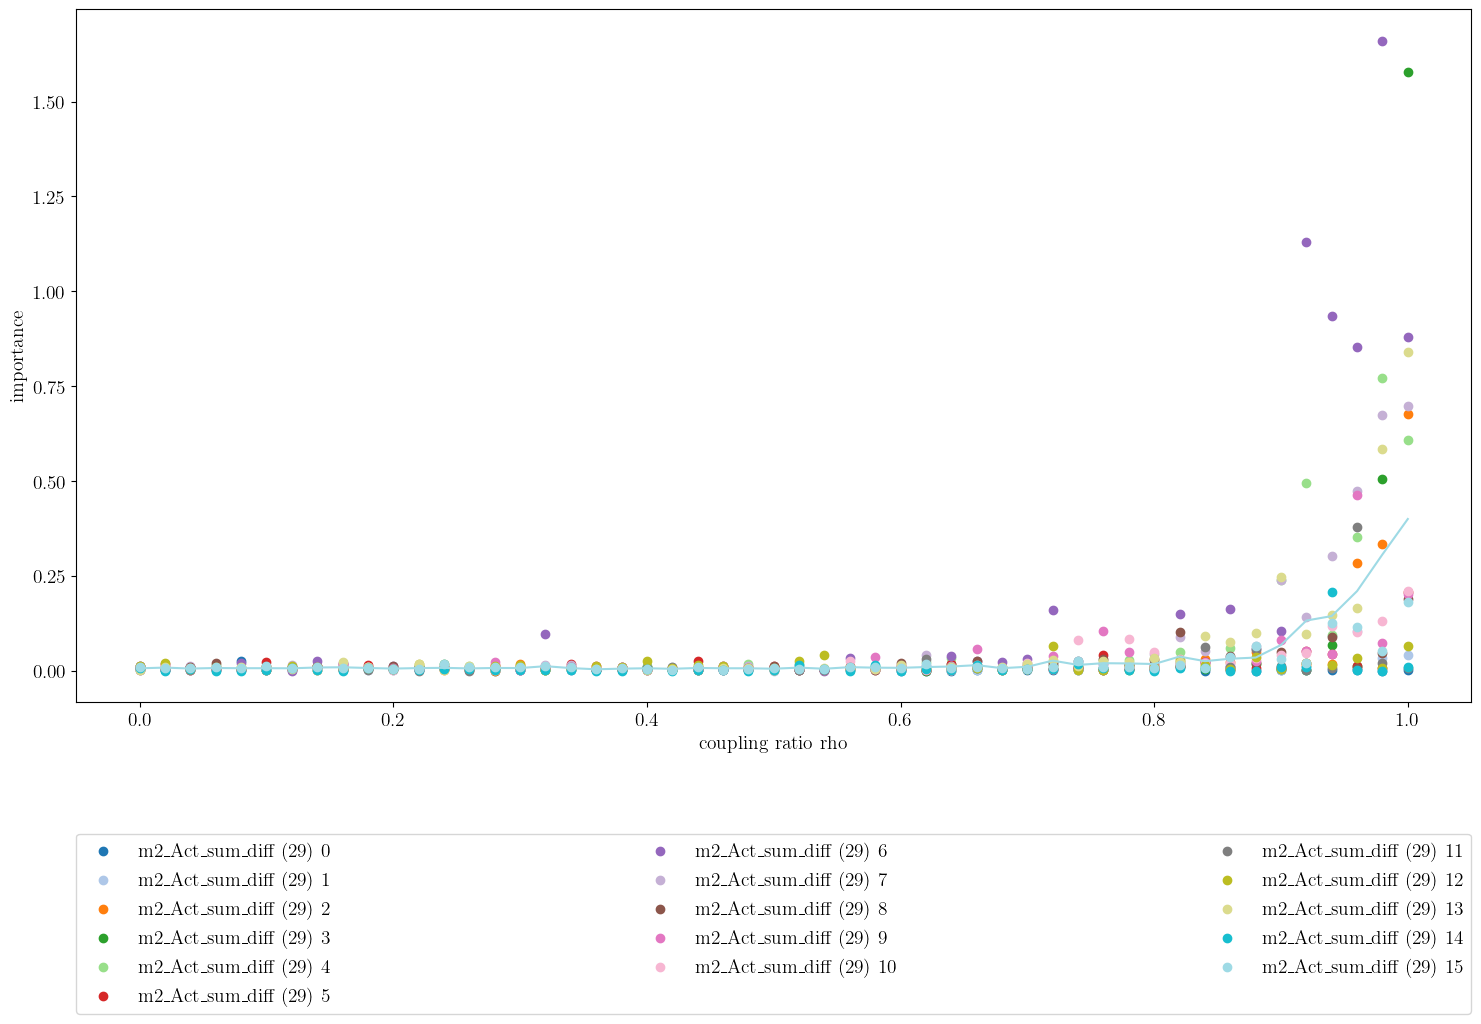

In [320]:
# MEASURES OVER SINGLE SEEDS

takeing = [29]  # ,12,16,18, 20] #range(len(ALL_MEASURES))
ls = ["dotted", "dashed", "solid"]

# colors = mpl.cm.tab20(np.linspace(0, 1, len(takeing)))
colors = mpl.cm.tab20(np.linspace(0, 1, iterations))
use_m = []
plt.figure(figsize=(18, 9))
for en, i in enumerate(takeing):
    plt.plot(
        BIASES,
        torch.mean(perseed_all[:, :, i], dim=1),
        linestyle=ls[int(l[1])],
        c=colors[num],
    )
    for num in range(iterations):
        l = ALL_MEASURES[i]
        label = f"{l} ({i}) {num}"
        vals = perseed_all[:, num, i]
        if l:  # .startswith("m2_mac")
            plt.scatter(
                BIASES,
                vals,
                label=label,
                linestyle=ls[int(l[1])],
                c=colors[num],
            )

# plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(
    bbox_to_anchor=(0.0, -0.45, 1.0, 0.102),
    loc="lower left",
    ncols=3,
    mode="expand",
    borderaxespad=0.0,
)

In [228]:
a = torch.zeros(8, 64, 64)
b = torch.zeros(8, 64, 64)
b[0, 54, 22:54] = 1

ms.cosine_distance(a, b)

1.0